In [ ]:
import gensim.downloader as api
from gensim.models import FastText
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE, trustworthiness
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap
import pandas as pd

In [2]:
%run ../database.ipynb

In [32]:
pretrained_model = api.load("word2vec-google-news-300")

df = pd.DataFrame(get_all_content())

corpus = df["preprocessed_token"]
y = df["siebert_sentiment_score"]

In [22]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Detected {num_cores} cores")

# Initialize FastText model
model = FastText(
    vector_size=300,
    window=5,
    min_count=5,
    sg=1,
    workers=num_cores - 1,  # Utilize all but one core
    batch_words=15000
)

# Build vocabulary and train the model
model.build_vocab(corpus)
total_examples = model.corpus_count

# Fine-tune with your corpus
model.build_vocab([list(pretrained_model.key_to_index.keys())], update=True)
model.train(corpus, total_examples=total_examples, epochs=20)

Detected 20 cores


(28352446, 41106320)

<h1>t-SNE Visualization 2D<h1>

In [ ]:

# Get word embeddings
words = list(model.wv.index_to_key)[:100000]
word_vectors = model.wv[words]

PCA Explained Variance: 0.4649


c:\Users\wwwhh\OneDrive\Desktop\fyp backend\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Final KL Divergence: 2.7669
Trustworthiness Score: 0.9820
Spearman Correlation for Distance Preservation: 0.6974


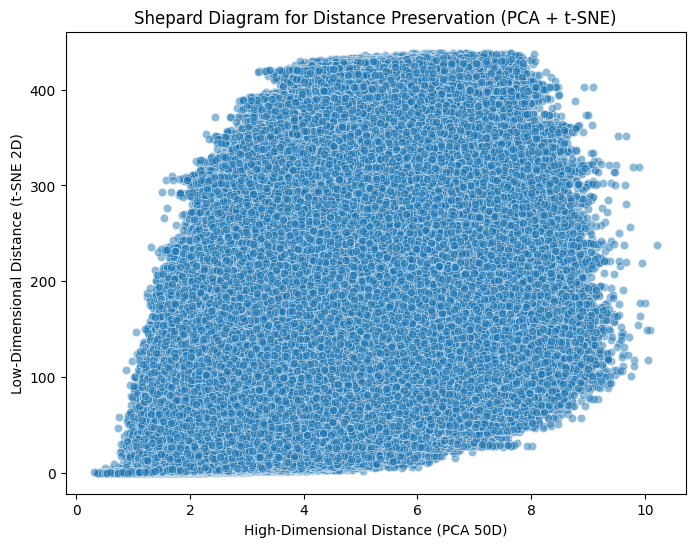

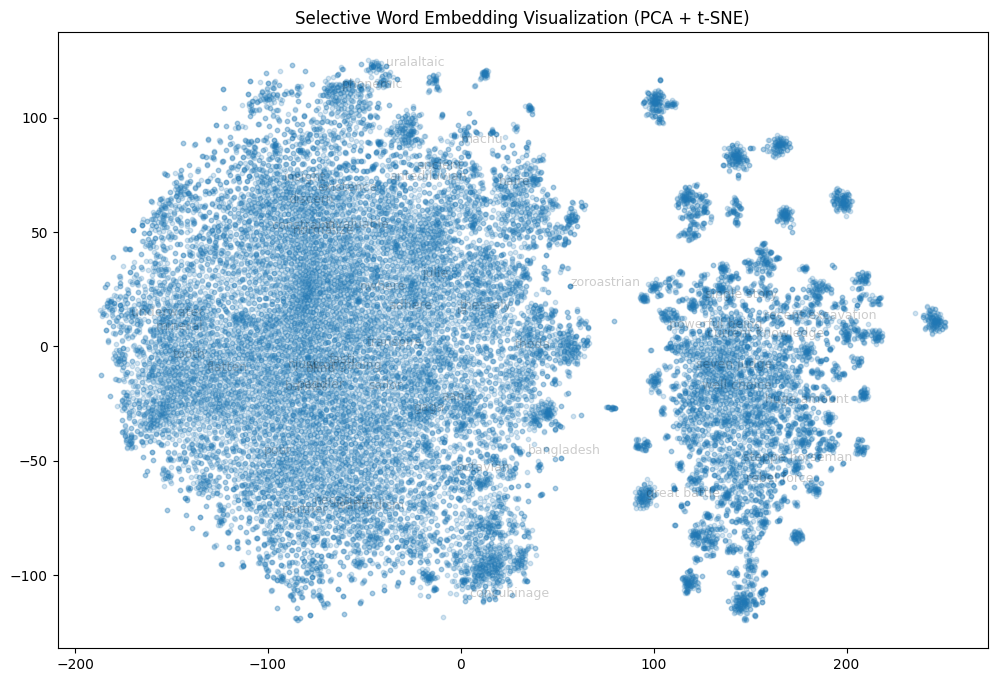

In [ ]:
pca = PCA(n_components=30, random_state=42)  # Reduce dimensions from 300 to 50
word_vectors_pca = pca.fit_transform(word_vectors)

# Explained variance ratio (optional: check how much info PCA retains)
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"PCA Explained Variance: {explained_variance:.4f}")  # Should be > 0.9 ideally

# ================================
# STEP 2: RUN t-SNE ON PCA-REDUCED DATA
# ================================
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=10000)
word_vecs_2d = tsne.fit_transform(word_vectors_pca)

# ================================
# STEP 3: EVALUATE t-SNE PERFORMANCE
# ================================

# 1. KL Divergence (t-SNE Loss)
print(f"Final KL Divergence: {tsne.kl_divergence_:.4f}")

# 2. Trustworthiness Score (Measures Local Structure Preservation)
trust_score = trustworthiness(word_vectors_pca, word_vecs_2d, n_neighbors=5)
print(f"Trustworthiness Score: {trust_score:.4f}")

# 3. Distance Preservation (Spearman Rank Correlation)
high_d_distances = pdist(word_vectors_pca, metric="euclidean")  # High-Dimensional distances
low_d_distances = pdist(word_vecs_2d, metric="euclidean")  # t-SNE 2D distances

correlation, _ = spearmanr(high_d_distances, low_d_distances)
print(f"Spearman Correlation for Distance Preservation: {correlation:.4f}")

# ================================
# STEP 4: PLOT SHEPARD DIAGRAM
# ================================
plt.figure(figsize=(8, 6))
sns.scatterplot(x=high_d_distances, y=low_d_distances, alpha=0.5)
plt.xlabel("High-Dimensional Distance (PCA 50D)")
plt.ylabel("Low-Dimensional Distance (t-SNE 2D)")
plt.title("Shepard Diagram for Distance Preservation (PCA + t-SNE)")
plt.show()

# ================================
# STEP 5: PLOT t-SNE VISUALIZATION (SELECTIVE WORDS)
# ================================
num_labels = 50  # Adjust to control how many words are labeled
indices = np.linspace(0, len(words) - 1, num_labels, dtype=int)

plt.figure(figsize=(12, 8))
plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], alpha=0.2, s=10)

# Annotate only selected words
for i in indices:
    plt.annotate(words[i], (word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=9, alpha=0.2)

plt.title("Selective Word Embedding Visualization (PCA + t-SNE)")
plt.show()

In [30]:
def get_sentence_vector(sentence, model):
    """Convert a sentence into a fixed-size vector by averaging word embeddings."""
    words = [word for word in sentence if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)  # Handle empty cases
    return np.mean([model.wv[word] for word in words], axis=0)

# Apply function to all texts
X = np.array([get_sentence_vector(text, model) for text in corpus])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

NameError: name 'feature_importance' is not defined

In [36]:
feature_importance = xgb_model.feature_importances_

feature_df = pd.DataFrame({
    'Feature_Index': np.arange(len(feature_importance)),
    'Importance': feature_importance
})

# Sort by importance
feature_df = feature_df.sort_values(by="Importance", ascending=False)
print(feature_df.head(10))  # Show top 10 most important features

     Feature_Index  Importance
282            282    0.018288
15              15    0.011971
101            101    0.010872
97              97    0.010413
199            199    0.009973
127            127    0.008234
115            115    0.007322
206            206    0.007024
58              58    0.006976
173            173    0.006883


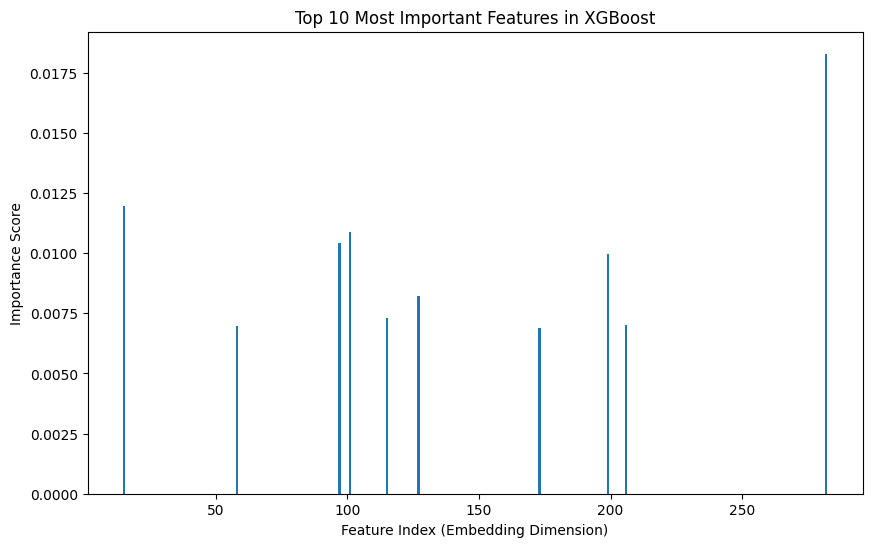

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(feature_df["Feature_Index"][:10], feature_df["Importance"][:10])
plt.xlabel("Feature Index (Embedding Dimension)")
plt.ylabel("Importance Score")
plt.title("Top 10 Most Important Features in XGBoost")
plt.show()

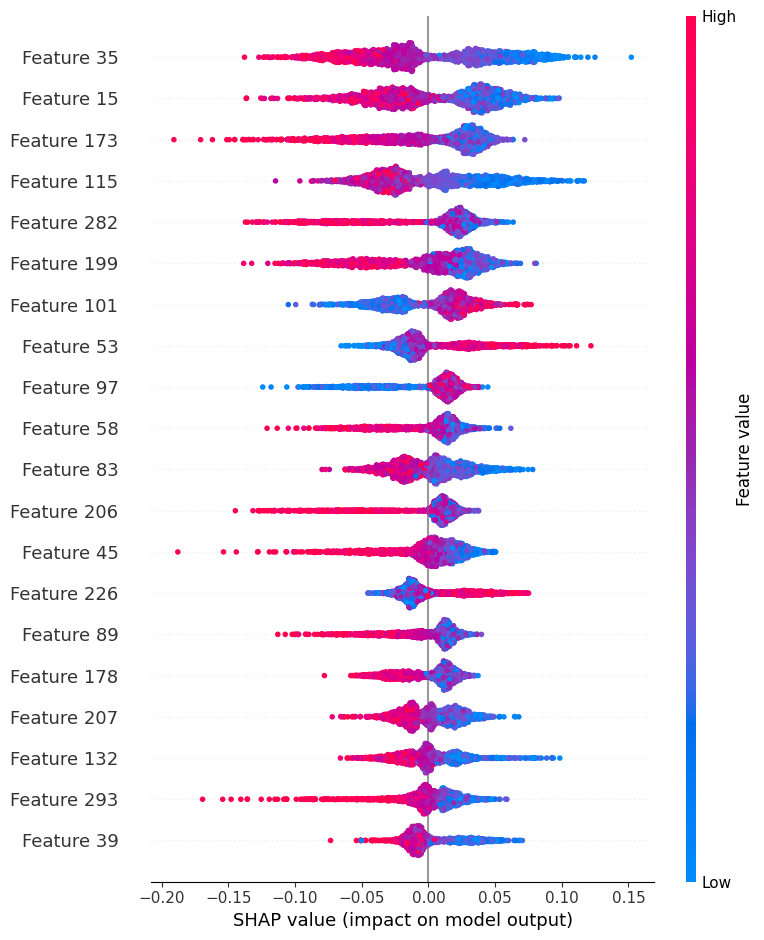

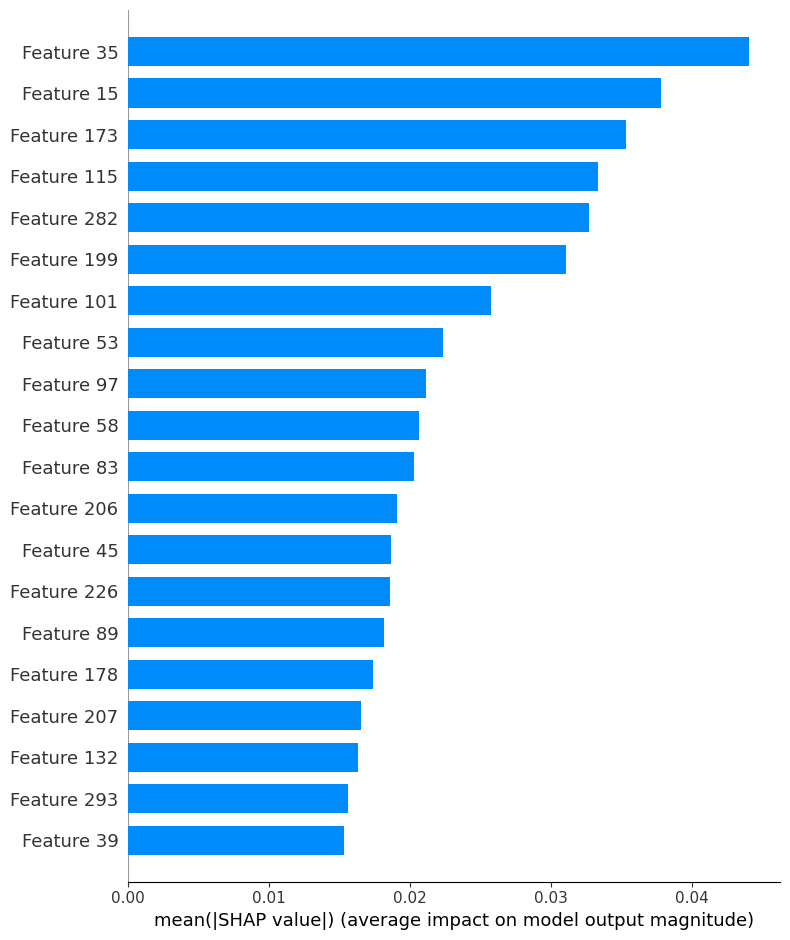

In [34]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

# SHAP Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar")

plt.show()